In [1]:
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import pandas as pd
import seaborn as sns
import xarray as xr
from matplotlib.colors import LinearSegmentedColormap

## Inputs and main parameters

In [2]:
vulnerable_pop_filepath = '../data/processed/vulnerable-pop.tif'
vulnerable_pop_aligned_filepath = '../data/processed/vulnerable-pop-aligned.tif'
scenarios_random_filepath = '../data/processed/scenarios-random.nc'
scenarios_vulnerable_filepath = '../data/processed/scenarios-vulnerable.nc'
T = 25
num_trees_plot = 35000

## Customization and utils for the plots

In [3]:
# custom cmap with transparent center
num_colors = 256
min_alpha = 0
color_arr = plt.get_cmap('YlGnBu')(range(num_colors))

# change alpha values
# color_arr[:, -1] = np.concatenate([
#     np.linspace(1.0, min_alpha, num_colors // 2),
#     np.linspace(min_alpha, 1.0, num_colors // 2)
# ])
color_arr[:, -1] = np.linspace(min_alpha, 1.0, num_colors)

cmap = LinearSegmentedColormap.from_list(name='custom', colors=color_arr)

# AX_MARGINS = dict(x=1000, y=5000)
margin_x = 1500
margin_y = 5000


def plot_da(da,
            ax,
            crs,
            cmap=None,
            ax_margins=None,
            title=None,
            clear_ax=True,
            **plot_kws):
    # agglom_extent_gdf.plot(ax=ax)
    da.plot(ax=ax, cmap=cmap, **plot_kws)
    minx, maxx = ax.get_xlim()
    ax.set_xlim(minx - margin_x, maxx + margin_x)
    miny, maxy = ax.get_ylim()
    ax.set_ylim(miny - margin_y, maxy + margin_y)
    # ax.set_ylim(miny - margin, maxy + margin)
    cx.add_basemap(ax=ax, crs=crs, attribution=False)
    if title:
        ax.set_title(title)
    if clear_ax:
        for axis_name in ['xaxis', 'yaxis']:
            getattr(ax, axis_name).set_visible(False)
    return ax


def plot_trees_dwellers(df, ax):
    sns.barplot(x='N. trees', y='N. dwellers', hue='Approach', data=df, ax=ax)
    ax.tick_params(axis='x', labelrotation=45)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    return ax

## Main data processing

In [4]:
# 1. read inputs
# agglom_extent_gdf = gpd.read_file(agglom_extent_filepath).iloc[:1]
scenario_random_ds = xr.open_dataset(scenarios_random_filepath)
scenario_vulnerable_ds = xr.open_dataset(scenarios_vulnerable_filepath)
scenario_runs = scenario_random_ds['scenario_run'].data
vulnerable_pop_da = xr.open_rasterio(vulnerable_pop_aligned_filepath).sel(
    band=1, drop=True)

# 2. compute total number of trees for the plots
total_trees = (
    scenario_vulnerable_ds['lulc'].isel(change_num=0) !=
    scenario_vulnerable_ds['lulc'].attrs['nodata']).values.sum()

# 3. rescale the resampled vulnerable population raster to have the same total
#    population as the original raster
def _total_pop(src):
    return np.where(src.dataset_mask(), src.read(1), 0).sum()
# TODO: this should be done at the time of warping
with rio.open(vulnerable_pop_filepath) as base_src:
    with rio.open(vulnerable_pop_aligned_filepath) as aligned_src:
        pop_rescale_factor = _total_pop(base_src) / _total_pop(aligned_src)

# 4. compute the dataframe of population exposed to high temperatures        
def sel_higher_random(T, scenario_run):
    return scenario_random_ds['T'].sel(scenario_run=scenario_run) > T

def sel_higher_vulnerable(T, scenario_run):
    return scenario_vulnerable_ds['T'] > T
df = pd.concat([
    pd.concat([
        pd.DataFrame(
            vulnerable_pop_da.where(scenario_sel(T, scenario_run)).sum(
                dim=['x', 'y']).to_series().rename('N. dwellers')).assign(
                    scenario_run=scenario_run, Approach=approach)
        for scenario_run in scenario_runs
    ]) for approach, scenario_sel in
    zip(['Random', 'Protect'],
        [sel_higher_random, sel_higher_vulnerable])
]).reset_index()
df['N. dwellers'] *= pop_rescale_factor
df['N. trees'] = df['change_num'].astype(np.int32)

## Create the figure

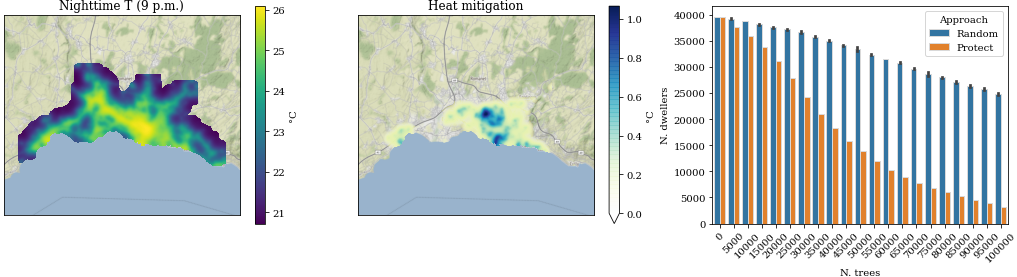

In [5]:
figwidth, figheight = plt.rcParams['figure.figsize']
fig, axes = plt.subplots(1, 3, figsize=(3 * figwidth, figheight))

start_da = scenario_vulnerable_ds['T'].sel(change_num=0)
crs = scenario_vulnerable_ds['T'].attrs['pyproj_srs']

cbar_kws = {'label': '°C'}
plot_da(start_da,
        axes[0],
        crs,
        title='Nighttime T (9 p.m.)',
        cbar_kwargs=cbar_kws)
plot_da(start_da - scenario_vulnerable_ds['T'].sel(change_num=num_trees_plot),
        axes[1],
        crs,
        cmap=cmap,
        title='Heat mitigation',
        cbar_kwargs=cbar_kws,
        vmin=0)
plot_trees_dwellers(df, axes[2])
fig.savefig('../reports/figures/figure.png')